# Lab 2: Neural Architecture Search
ELEC70109/EE9-AML3-10/EE9-AO25


## Task 1 - IntegerLinear with different widths

## 1.a 
We modify the `construct_model` function to include the `LinearInteger`, and add the `width` and `frac_width` parameters to the `search_space` dictionary. 

```python

search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,

    ],
    "width_choices": [8, 16, 32],
    "frac_width_choices": [2, 4, 8],
}


def construct_model(trial):

    # Fetch the model
    trial_model = deepcopy(base_model)

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # If the chosen layer is integer, define the low precision config
            if new_layer_cls == LinearInteger:
                width = trial.suggest_categorical(
                    "width",
                    search_space["width_choices"],
                )
                frac_width = trial.suggest_categorical(
                    "frac_width",
                    search_space["frac_width_choices"],
                )
                kwargs["config"] = {
                    "data_in_width":width,
                    "data_in_frac_width": frac_width,
                    "weight_width":width, 
                    "weight_frac_width": frac_width,
                    "bias_width": width,
                    "bias_frac_width": frac_width,
                }
            # elif... (other precisions)

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)
```

## 1.b

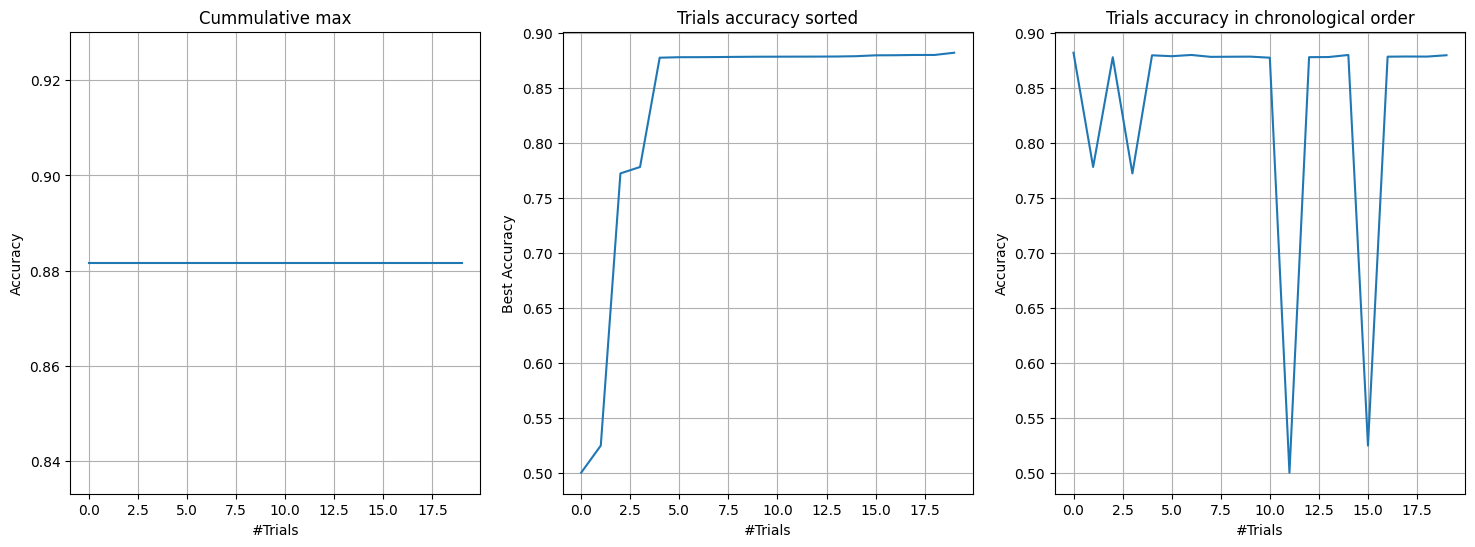

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

study_linear = pd.read_csv("results_3_1.csv")
trials = study_linear.number
values_linear = study_linear.value
sorted_values_linear = values_linear.sort_values()
max_values_linear = values_linear.cummax()


fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot without sorted values
ax[1].plot(trials, sorted_values_linear)
ax[1].set_xlabel("#Trials")
ax[1].set_ylabel("Best Accuracy")
ax[1].grid()
ax[1].set_title("Trials accuracy sorted")

# Plot with sorted values
ax[0].plot(
    trials,
    max_values_linear,
)
ax[0].set_xlabel("#Trials")
ax[0].set_ylabel("Accuracy")
ax[0].grid()
ax[0].set_title("Cummulative max")

# Plot all the accuracy values in order
ax[2].plot(trials, values_linear)
ax[2].set_xlabel("#Trials")
ax[2].set_ylabel("Accuracy")
ax[2].grid()
ax[2].set_title("Trials accuracy in chronological order")

plt.show()

We were lucky this time, as it seems that the sampler has found the best configuration during the first trial.

In [8]:
from utils import get_trial_config

config = get_trial_config(study_linear, 5)
config

{'params_bert.encoder.layer.0.attention.self.key_type': "<class 'chop.nn.quantized.modules.linear.LinearInteger'>",
 'params_bert.encoder.layer.0.intermediate.dense_type': "<class 'chop.nn.quantized.modules.linear.LinearInteger'>",
 'params_bert.encoder.layer.0.output.dense_type': "<class 'torch.nn.modules.linear.Linear'>",
 'params_bert.encoder.layer.1.attention.output.dense_type': "<class 'torch.nn.modules.linear.Linear'>",
 'params_bert.encoder.layer.1.attention.self.key_type': "<class 'chop.nn.quantized.modules.linear.LinearInteger'>",
 'params_bert.encoder.layer.1.intermediate.dense_type': "<class 'torch.nn.modules.linear.Linear'>",
 'params_bert.encoder.layer.1.output.dense_type': "<class 'chop.nn.quantized.modules.linear.LinearInteger'>",
 'params_classifier_type': "<class 'torch.nn.modules.linear.Linear'>",
 'params_frac_width': 4,
 'params_width': 32}

# Task 2

## 2.a 

We modify the `construct_model` function to include more layer types.

```python

search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
        LinearMinifloatDenorm,
        LinearMinifloatIEEE,
    ],
    "width_choices": [8, 16, 32],
    "frac_width_choices": [2, 4, 8],
}

def construct_model(trial):

    # Fetch the model
    trial_model = deepcopy(base_model)

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # If the chosen layer is integer, define the low precision config
            if new_layer_cls == LinearInteger:
                width = trial.suggest_categorical(
                    "width",
                    search_space["width_choices"],
                )
                frac_width = trial.suggest_categorical(
                    "frac_width",
                    search_space["frac_width_choices"],
                )
                kwargs["config"] = {
                    "data_in_width": width,
                    "data_in_frac_width": frac_width,
                    "weight_width": width,
                    "weight_frac_width": frac_width,
                    "bias_width": width,
                    "bias_frac_width": frac_width,
                }
            elif new_layer_cls == LinearMinifloatDenorm:
                width = trial.suggest_categorical(
                    "width",
                    search_space["width_choices"],
                )
                exponent_width = trial.suggest_categorical(
                    "exponent_width",
                    search_space["frac_width_choices"],
                )
                exponent_bias = trial.suggest_categorical(
                    "exponent_bias",
                    search_space["frac_width_choices"],
                )
                kwargs["config"] = {
                    "data_in_width": width,
                    "data_in_exponent_width": exponent_width,
                    "data_in_exponent_bias": exponent_bias,
                    "weight_width": width,
                    "weight_exponent_width": exponent_width,
                    "weight_exponent_bias": exponent_bias,
                    "bias_width": width,
                    "bias_exponent_width": exponent_width,
                    "bias_exponent_bias": exponent_bias,
                }

            elif new_layer_cls == LinearMinifloatIEEE:
                width = trial.suggest_categorical(
                    "width",
                    search_space["width_choices"],
                )
                exponent_width = trial.suggest_categorical(
                    "exponent_width",
                    search_space["frac_width_choices"],
                )
                exponent_bias = trial.suggest_categorical(
                    "exponent_bias",
                    search_space["frac_width_choices"],
                )
                kwargs["config"] = {
                    "data_in_width": width,
                    "data_in_exponent_width": exponent_width,
                    "data_in_exponent_bias": exponent_bias,
                    "weight_width": width,
                    "weight_exponent_width": exponent_width,
                    "weight_exponent_bias": exponent_bias,
                    "bias_width": width,
                    "bias_exponent_width": exponent_width,
                    "bias_exponent_bias": exponent_bias,
                }

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)

    return trial_model
```

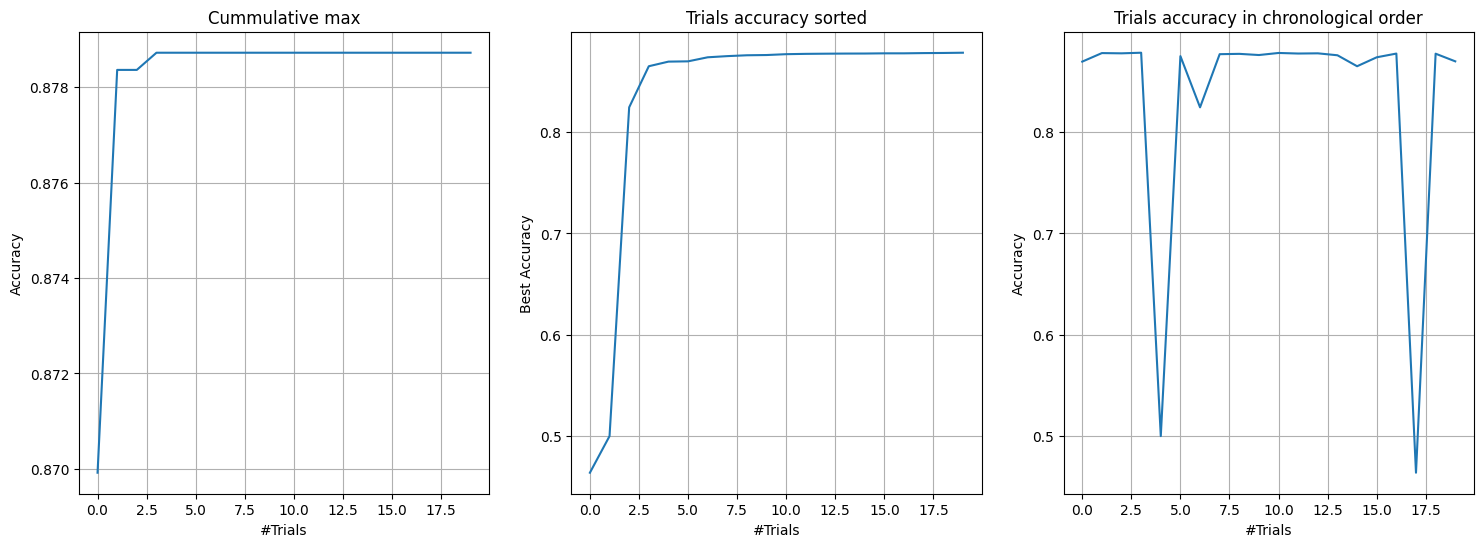

In [9]:
study_linear_2 = pd.read_csv("results_3_2.csv")
trials = study_linear_2.number
values_linear_2 = study_linear_2.value
sorted_values_linear_2 = values_linear_2.sort_values()
max_values_linear_2 = values_linear_2.cummax()


fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot without sorted values
ax[1].plot(trials, sorted_values_linear_2)
ax[1].set_xlabel("#Trials")
ax[1].set_ylabel("Best Accuracy")
ax[1].grid()
ax[1].set_title("Trials accuracy sorted")

# Plot with sorted values
ax[0].plot(
    trials,
    max_values_linear_2,
)
ax[0].set_xlabel("#Trials")
ax[0].set_ylabel("Accuracy")
ax[0].grid()
ax[0].set_title("Cummulative max")

# Plot all the accuracy values in order
ax[2].plot(trials, values_linear_2)
ax[2].set_xlabel("#Trials")
ax[2].set_ylabel("Accuracy")
ax[2].grid()
ax[2].set_title("Trials accuracy in chronological order")

plt.show()

In [10]:
config = get_trial_config(study_linear_2, 5)
config

{'params_bert.encoder.layer.0.attention.self.key_exponent_bias': nan,
 'params_bert.encoder.layer.0.attention.self.key_exponent_width': nan,
 'params_bert.encoder.layer.0.attention.self.key_frac_width': nan,
 'params_bert.encoder.layer.0.attention.self.key_type': "<class 'torch.nn.modules.linear.Linear'>",
 'params_bert.encoder.layer.0.attention.self.key_width': nan,
 'params_bert.encoder.layer.0.intermediate.dense_exponent_bias': 2.0,
 'params_bert.encoder.layer.0.intermediate.dense_exponent_width': 4.0,
 'params_bert.encoder.layer.0.intermediate.dense_frac_width': nan,
 'params_bert.encoder.layer.0.intermediate.dense_type': "<class 'chop.nn.quantized.modules.linear.LinearMinifloatDenorm'>",
 'params_bert.encoder.layer.0.intermediate.dense_width': 8.0,
 'params_bert.encoder.layer.0.output.dense_exponent_bias': nan,
 'params_bert.encoder.layer.0.output.dense_exponent_width': nan,
 'params_bert.encoder.layer.0.output.dense_frac_width': 2.0,
 'params_bert.encoder.layer.0.output.dense_typ

In [11]:
study_linear_2

,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_bert.encoder.layer.0.attention.self.key_exponent_bias,params_bert.encoder.layer.0.attention.self.key_exponent_width,params_bert.encoder.layer.0.attention.self.key_frac_width,params_bert.encoder.layer.0.attention.self.key_type,...,params_bert.encoder.layer.1.output.dense_frac_width,params_bert.encoder.layer.1.output.dense_type,params_bert.encoder.layer.1.output.dense_width,params_classifier_exponent_bias,params_classifier_exponent_width,params_classifier_frac_width,params_classifier_type,params_classifier_width,user_attrs_model,state
0,0,0,0.86992,2025-02-12 17:24:56.116738,2025-02-12 17:29:16.042001,0 days 00:04:19.925263,NaN,NaN,2.0,<class 'chop.nn.quantized.modules.linear.Linea...,...,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,16.0,4.0,2.0,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,16.0,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
1,1,1,0.87836,2025-02-12 17:29:16.051048,2025-02-12 17:33:23.651153,0 days 00:04:07.600105,8.0,2.0,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,...,NaN,<class 'torch.nn.modules.linear.Linear'>,NaN,8.0,4.0,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,8.0,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
2,2,2,0.87812,2025-02-12 17:33:23.663742,2025-02-12 17:36:28.797291,0 days 00:03:05.133549,NaN,NaN,4.0,<class 'chop.nn.quantized.modules.linear.Linea...,...,NaN,<class 'torch.nn.modules.linear.Linear'>,NaN,NaN,NaN,NaN,<class 'torch.nn.modules.linear.Linear'>,NaN,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
3,3,3,0.87872,2025-02-12 17:36:28.806292,2025-02-12 17:40:29.443093,0 days 00:04:00.636801,NaN,NaN,NaN,<class 'torch.nn.modules.linear.Linear'>,...,NaN,<class 'torch.nn.modules.linear.Linear'>,NaN,2.0,8.0,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,32.0,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
4,4,4,0.49968,2025-02-12 17:40:29.451920,2025-02-12 17:46:31.140421,0 days 00:06:01.688501,2.0,2.0,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,...,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,16.0,4.0,8.0,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,8.0,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
5,5,5,0.87536,2025-02-12 17:46:31.149849,2025-02-12 17:51:04.427072,0 days 00:04:33.277223,NaN,NaN,NaN,<class 'torch.nn.modules.linear.Linear'>,...,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,8.0,NaN,NaN,NaN,<class 'torch.nn.modules.linear.Linear'>,NaN,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
6,6,6,0.82472,2025-02-12 17:51:04.436765,2025-02-12 17:55:24.527316,0 days 00:04:20.090551,2.0,8.0,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,...,NaN,<class 'torch.nn.modules.linear.Linear'>,NaN,NaN,NaN,NaN,<class 'torch.nn.modules.linear.Linear'>,NaN,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
7,7,7,0.87728,2025-02-12 17:55:24.536536,2025-02-12 17:59:33.995421,0 days 00:04:09.458885,4.0,8.0,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,...,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,32.0,NaN,NaN,NaN,<class 'torch.nn.modules.linear.Linear'>,NaN,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
8,8,8,0.87760,2025-02-12 17:59:34.005750,2025-02-12 18:05:13.297664,0 days 00:05:39.291914,4.0,4.0,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,...,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,8.0,2.0,8.0,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,32.0,BertForSequenceClassification(\n (bert): Bert...,COMPLETE
9,9,9,0.87644,2025-02-12 18:05:13.306668,2025-02-12 18:09:19.829019,0 days 00:04:06.522351,8.0,8.0,NaN,<class 'chop.nn.quantized.modules.linear.Linea...,...,2.0,<class 'chop.nn.quantized.modules.linear.Linea...,16.0,NaN,NaN,NaN,<class 'torch.nn.modules.linear.Linear'>,NaN,BertForSequenceClassification(\n (bert): Bert...,COMPLETE


In [15]:
md = study_linear_2.to_markdown("results_3_2.md")

In [12]:
# Group results by params_width
grouped_2 = study_linear_2[["value", "params_width"]].groupby("params_width").mean()

# Plot the results
plt.plot(grouped_2.index, grouped_2.value)
plt.xlabel("Total FP Width")
plt.ylabel("Mean Accuracy")
plt.grid()
plt.title("Mean accuracy for different FP Widths")

plt.show()

KeyError: "['params_width'] not in index"

In [ ]:
# Find the best value
best_width = study_linear_2.value.idxmax()
print("Best config : ")
study_linear_2.loc[best_width][
    [
        "value",
        "params_exponent_bias",
        "params_exponent_width",
        "params_frac_width",
        "params_width",
    ]
].to_frame()

Best config : 


,16
value,0.86468
params_exponent_bias,2
params_exponent_width,4
params_frac_width,4.0
params_width,16
